In [ ]:
!pip install contractions
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/LIDCI/5/PROCESAMIENTO DE LENGUAJE NATURAL/HateSpeech (1) (1).csv')
df = df[['class','tweet']]
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df['class'].unique()

array([2, 1, 0])

0: hate speech
1: offensive
2: Neither

<Axes: xlabel='class'>

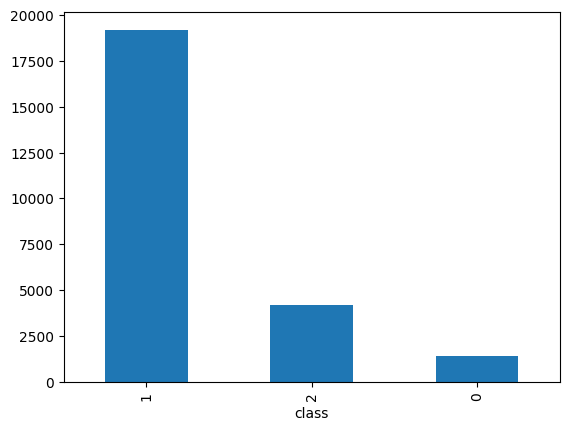

In [ ]:
df['class'].value_counts().plot(kind='bar')

aqui se ponen los cambios de undersampling

In [ ]:
undersampled_data = pd.DataFrame(columns=['class','tweet'])
undersampled_data =pd.concat([undersampled_data,df[df['class']==0]])
undersampled_data =pd.concat([undersampled_data,df[df['class']==1].sample(1430)])
undersampled_data =pd.concat([undersampled_data,df[df['class']==2].sample(1430)])
df = undersampled_data
df.reset_index(inplace=True)

<Axes: xlabel='class'>

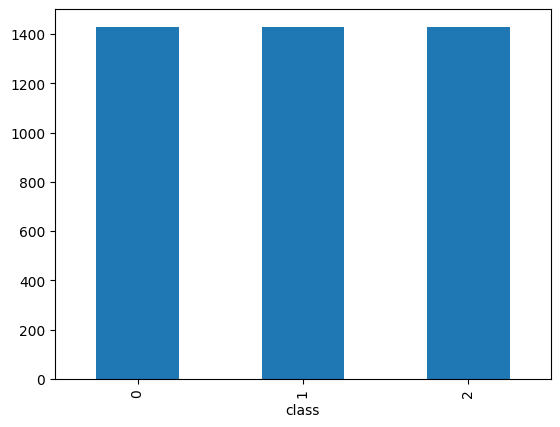

In [ ]:
df['class'].value_counts().plot(kind='bar')

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import contractions
import spacy

nlp = spacy.load('en_core_web_lg')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
stop_words_en = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
def vectorize(texto):
    texto=texto.lower()
    texto = contractions.fix(texto)
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)
    texto = re.sub(r'[^0-9A-Za-z \t]', '', texto)
    texto = re.sub(r'^\w+:\/\/\S+', '', texto)
    texto = re.sub(r'rt', '', texto)
    texto_tokenized= word_tokenize(texto)
    texto_no_stop = [token for token in texto_tokenized if token not in stop_words_en]
    final= [lemmatizer.lemmatize (word) for word in texto_no_stop]
    final = ' '.join(final)
    texto = nlp(final).vector
    return texto

In [ ]:
from tqdm import tqdm
nltk.download('punkt_tab')
tqdm.pandas()
df['vector'] = df['tweet'].progress_apply(vectorize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 4290/4290 [00:42<00:00, 100.30it/s]


In [ ]:
df.head()

,index,class,tweet,vector
0,85,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...","[0.014327997, -0.19375, 0.0560356, 0.20434001,..."
1,89,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ...","[-0.07016367, 0.04923667, -0.036391113, -0.167..."
2,110,0,"""@DevilGrimz: @VigxRArts you're fucking gay, b...","[-0.13298438, -0.1632348, -0.080808, -0.066177..."
3,184,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...","[-0.2662789, 0.0017642246, -0.11928078, -0.331..."
4,202,0,"""@NoChillPaz: ""At least I'm not a nigger"" http...","[-0.2510075, -0.060877495, -0.036019, -0.22616..."


In [ ]:
from sklearn.model_selection import train_test_split
X = df['vector']
X = np.concatenate(X,axis=0).reshape(-1,300)
y=df['class']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.7,
                                                    random_state=101,
                                                    stratify=y)

startify asegura la prescencia de todas las clases en todos los sets

In [ ]:
y_train

,class
3897,2
2397,1
3292,2
2553,1
3804,2
...,...
532,0
3176,2
1179,0
3663,2


In [ ]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [ ]:
y_train = to_categorical(y_train,3)
y_test = to_categorical(y_test,3)

In [ ]:
y_train

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [ ]:
model = Sequential()
model.add(Dense(units=128,activation='relu',input_dim=300))
model.add(Dropout(0.35))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=10,
                    epochs=20,
                    validation_data=(X_test,y_test))

Epoch 1/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6744 - loss: 0.7781 - val_accuracy: 0.6923 - val_loss: 0.6773
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7618 - loss: 0.6322 - val_accuracy: 0.7552 - val_loss: 0.6419
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7675 - loss: 0.5747 - val_accuracy: 0.7537 - val_loss: 0.6457
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7820 - loss: 0.5810 - val_accuracy: 0.7483 - val_loss: 0.7432
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7830 - loss: 0.5546 - val_accuracy: 0.7677 - val_loss: 0.6187
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7977 - loss: 0.5361 - val_accuracy: 0.7490 - val_loss: 0.7066
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7961 - loss: 0.5056 - val_accuracy: 0.7514 - val_loss: 0.6709
Epoch 8/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8085 - loss: 0.5234 - val_accuracy: 0.

In [ ]:
metrics = pd.DataFrame(history.history)
metrics

,accuracy,loss,val_accuracy,val_loss
0,0.709291,0.724841,0.692308,0.677299
1,0.760906,0.619069,0.755245,0.641875
2,0.775558,0.576158,0.753691,0.645714
3,0.774892,0.596796,0.748252,0.743228
4,0.792874,0.540768,0.767677,0.618717
5,0.795205,0.533041,0.749029,0.706562
6,0.793540,0.538901,0.751360,0.670860
7,0.798868,0.538308,0.741259,0.653539
8,0.802198,0.502513,0.760684,0.631906
9,0.817183,0.462590,0.747475,0.743333


<Axes: >

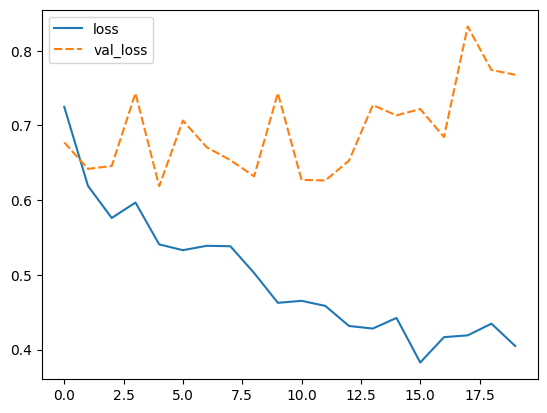

In [ ]:
import seaborn as sns
sns.lineplot(data=metrics[['loss', 'val_loss']])

<Axes: >

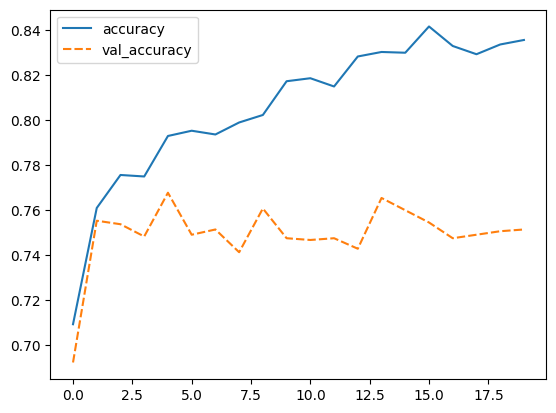

In [ ]:
sns.lineplot(data=metrics[['accuracy', 'val_accuracy']])

In [ ]:
y_pred = model.predict(X_test)
y_pred

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[8.4219056e-01, 1.5225731e-01, 5.5521419e-03],
       [7.1260328e-03, 2.4781248e-03, 9.9039584e-01],
       [6.1370019e-07, 9.9999928e-01, 9.6214151e-08],
       ...,
       [6.0522849e-05, 9.9987841e-01, 6.1021972e-05],
       [8.2391351e-01, 1.6680121e-01, 9.2852488e-03],
       [5.6021297e-01, 4.3494186e-01, 4.8451349e-03]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=-1)
y_pred

array([0, 2, 1, ..., 1, 0, 0])

In [ ]:
y_test = np.argmax(y_test, axis=-1)
y_test

array([0, 2, 1, ..., 1, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       429
           1       0.74      0.73      0.73       429
           2       0.84      0.84      0.84       429

    accuracy                           0.75      1287
   macro avg       0.75      0.75      0.75      1287
weighted avg       0.75      0.75      0.75      1287



<Axes: >

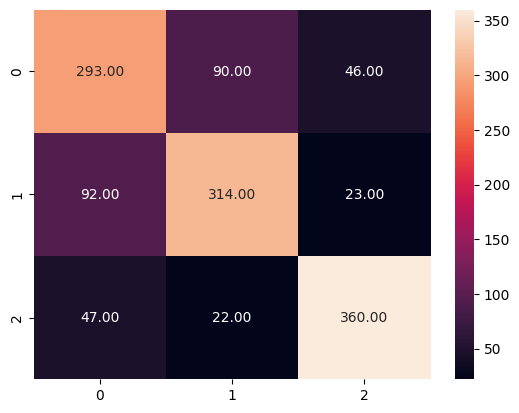

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.2f')

In [ ]:
df[df['class']==0]['tweet'].iloc[70]

'&#8220;@My_Fish_Died: You dammn Weed potheads are annoying af on Twitter&#8221; weed and pot are the same thing faggot'

In [ ]:
df[df['class']==1]['tweet'].iloc[70]

'Fck dem old hoes..... No double entree...'